# Lab  - Trees, Forests, and Classification
- **Author:** Suraj R. Nair, based on previous material from Emily Aiken.
- **Date:** March 13, 2024
- **Course:** INFO 251: Applied machine learning

## Topics:
1. Decision Trees
2. Random Forests
3. Classification performance metrics

## Learning Goals:
At the end of this lab, you will...
- Understand the recursive algorithm to grow a decision tree
- Know the standard splitting criteria used for decision trees
- Understand how feature importances are calculated for decision trees
- Know the main hyperparameters for decision trees and random forests, and how to tune them to prevent overfitting
- Know the main performance measures for classification: accuracy, TPR, FPR, precision, and recall
- Understand ROC curves, precision and recall plots, and methods for determining the "optimal" classification threshold

## Resources:
- [Feature importances in random forests](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score

### III. Over to you!
Let's revisit an old friend -- the [California Housing Dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing):
- The goal is to predict median housing value, using the available features. 
- Note that this is now a regression task
- Train a decision tree, try tuning *maximum depth* and report best r2
- Train a random forest, try tuning *maximum depth*, *n_estimators* and report best r2
- Calculate the feature importances for the best random forest, show mean and standard deviation in impurity decrease

You should be able to achieve an r2 score of above 0.70 on the test set using your well-tuned random forest.

In [58]:
data = datasets.fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

In [59]:
train, test = train_test_split(df, shuffle=True, test_size=0.25, random_state=0)
x_train, y_train = train.drop('target', axis=1), train['target']
x_test, y_test = test.drop('target', axis=1), test['target']

In [60]:
# Untuned decision tree
model = DecisionTreeRegressor(random_state=1)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('r2 (train): %.2f' % r2_score(y_train, yhat_train))
print('r2 (test): %.2f' % r2_score(y_test, yhat_test))

r2 (train): 1.00
r2 (test): 0.59


In [61]:
# Tuned decision tree
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10, 12, 14]}
cv_model = GridSearchCV(model, param_grid=params, scoring='r2', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)

model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])

print('r2 (train): %.2f' % r2_score(y_train, yhat_train))
print('r2 (test): %.2f' % r2_score(y_test, yhat_test))

Best maximum depth: 8
r2 (train): 0.76
r2 (test): 0.66


In [62]:
# Random Forest
model = RandomForestRegressor(random_state=1)
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8, 10], 'n_estimators':[25, 50, 100]}
cv_model = GridSearchCV(model, param_grid=params, scoring='r2', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])

print('r2 (train): %.2f' % r2_score(y_train, yhat_train))
print('r2 (test): %.2f' % r2_score(y_test, yhat_test))

Best maximum depth: 10
Best number of estimators: 100
r2 (train): 0.87
r2 (test): 0.76


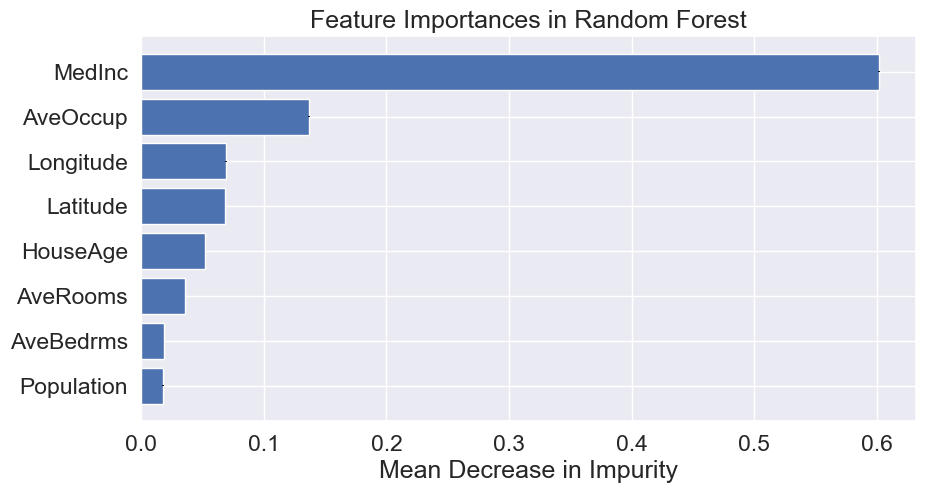

In [63]:
# Feature Importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(1, figsize=(10, 5))
plt.barh(importances['Feature'], importances['Importance'], yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Random Forest')
plt.show()